# Bike rental prediction project
The goal of this notebook is to demonstrate several different regression models to predict bike rentals. For this project the  kaggle "Bike Sharing Demand" data set was used : https://www.kaggle.com/competitions/bike-sharing-demand/overview. 

### Used Regression Models

In total several different regression models were used and optimized:
- linear regression
- lasso regression
- random forest regresson
- ridge regression
- poisson regression
The optimization of hyper parameters is just an example to demonstrate the workflow and possibilities. For final optimization more computing power would be needed.


The dataset contains hourly bike rental data for two years with the following data fields:

### Data fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals


### Workflow

- import the data
- exploratory data analysis
- feature engineering
- train different regression models
- hyperparameter optimization
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import PoissonRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

# Import data and add columns

In [2]:
# read in the .csv file
df = pd.read_csv('../data/train.csv', index_col = 0, parse_dates=True)
df.sample(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-12-17 19:00:00,4,0,0,3,9.84,10.605,65,22.0028,11,95,106
2012-02-06 08:00:00,1,0,1,1,6.56,9.090,86,8.9981,10,434,444
2012-02-01 08:00:00,1,0,1,3,14.76,18.180,73,7.0015,15,505,520


In [3]:
#Create extra date/time columns out of the datetime index
df['months_num'] = df.index.month
df['months_name'] = df.index.month_name()
df['day_of_week_num'] = df.index.dayofweek
df['day_of_week'] = df.index.day_name()
df['hours'] = df.index.hour
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear
df.sample(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,months_num,months_name,day_of_week_num,day_of_week,hours,year,day_of_year
datetime,,,,,,,,,,,,,,,,,,
2011-07-16 14:00:00,3,0,0,1,30.34,33.335,45,19.9995,201,232,433,7,July,5,Saturday,14,2011,197
2011-11-18 12:00:00,4,0,1,1,13.12,16.665,33,0.0000,22,143,165,11,November,4,Friday,12,2011,322
2011-03-04 23:00:00,1,0,1,2,12.30,15.150,75,11.0014,6,40,46,3,March,4,Friday,23,2011,63


# Exploratory Data Analysis

In [4]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,months_num,day_of_week_num,hours,year,day_of_year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,6.521495,3.013963,11.541613,2011.501929,177.562466
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,3.444373,2.004585,6.915838,0.500019,105.055551
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2011.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,4.000000,1.000000,6.000000,2011.000000,92.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,7.000000,3.000000,12.000000,2012.000000,182.500000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,10.000000,5.000000,18.000000,2012.000000,274.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,12.000000,6.000000,23.000000,2012.000000,354.000000


### Heatmap Correlation

<AxesSubplot:>

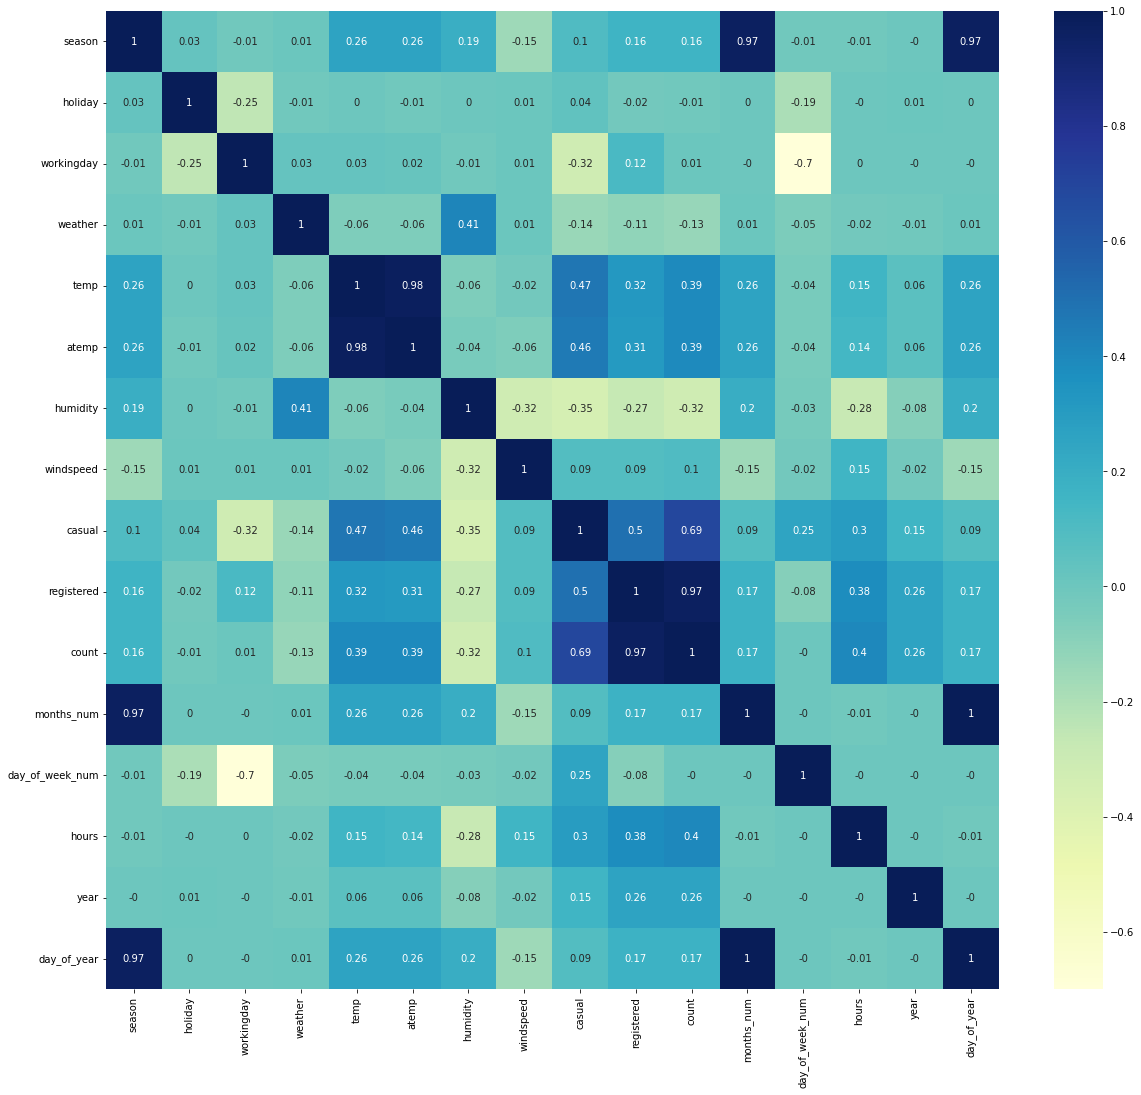

In [5]:
plt.figure(figsize=(20,18))
sns.heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")

In [6]:
#check for nan
df.isna().sum()

season             0
holiday            0
workingday         0
weather            0
temp               0
atemp              0
humidity           0
windspeed          0
casual             0
registered         0
count              0
months_num         0
months_name        0
day_of_week_num    0
day_of_week        0
hours              0
year               0
day_of_year        0
dtype: int64

In [7]:
df_describe = df.groupby(['day_of_week_num','day_of_week']).describe()
df_describe['count']

,,count,mean,std,min,25%,50%,75%,max
day_of_week_num,day_of_week,,,,,,,,
0,Monday,1551.0,190.390716,180.943376,1.0,39.0,146.0,277.5,968.0
1,Tuesday,1539.0,189.723847,186.719673,1.0,36.0,146.0,274.0,970.0
2,Wednesday,1551.0,188.411348,190.942004,1.0,38.0,136.0,270.5,977.0
3,Thursday,1553.0,197.296201,187.606619,1.0,44.0,155.0,280.0,901.0
4,Friday,1529.0,197.844343,172.518208,1.0,52.0,167.0,290.0,900.0
5,Saturday,1584.0,196.665404,180.917795,1.0,45.0,141.5,309.5,783.0
6,Sunday,1579.0,180.839772,167.022145,1.0,43.0,119.0,298.0,757.0


### Plot number of casual bike users vs registered bike users 

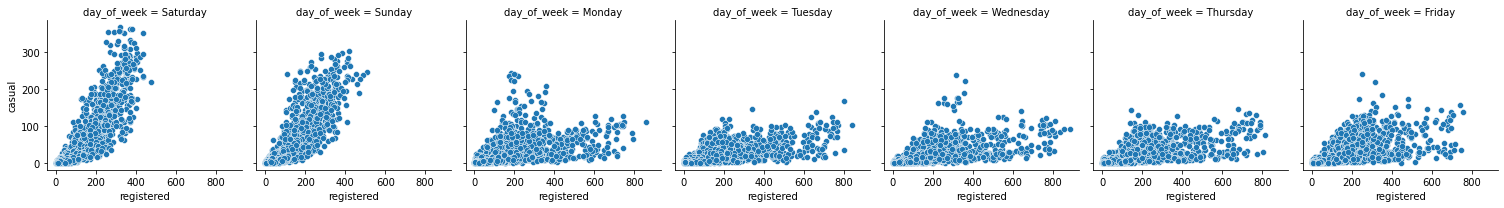

In [8]:
#One single scatterplot for each day of the week
g = sns.FacetGrid(df, col="day_of_week", margin_titles=True)
g.map(sns.scatterplot, "registered", "casual")

<AxesSubplot:xlabel='registered', ylabel='casual'>

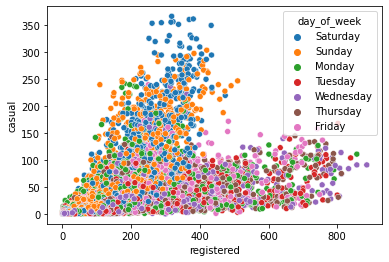

In [9]:
# Scatterplot for all days in one plot
sns.scatterplot(data=df, x = df['registered'], y = df['casual'], hue = 'day_of_week' )

<AxesSubplot:xlabel='registered', ylabel='casual'>

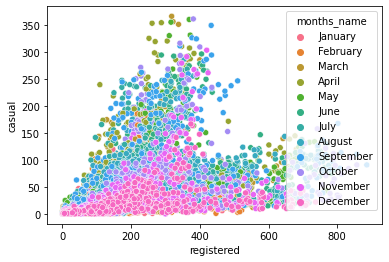

In [10]:
# Scatterplot for months in one plot
sns.scatterplot(data=df, x = df['registered'], y = df['casual'], hue = 'months_name' )

<AxesSubplot:xlabel='day_of_week', ylabel='casual'>

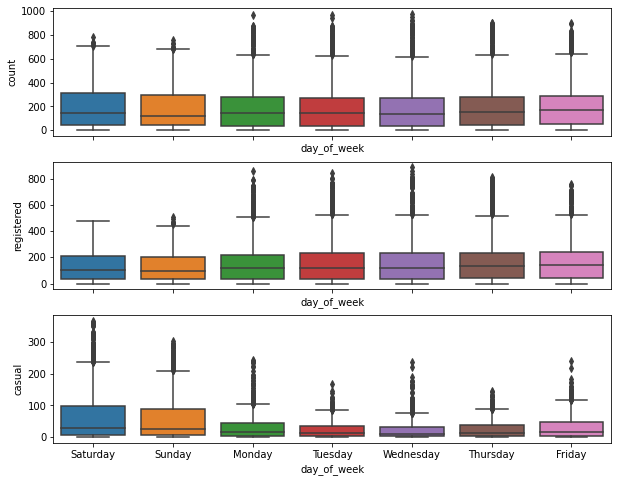

In [11]:

fig, axs  = plt.subplots(3,1, figsize = (10,8),sharex=True)
sns.boxplot(data = df , x = 'day_of_week', y = 'count', ax=axs[0])
sns.boxplot(data = df , x = 'day_of_week', y = 'registered', ax=axs[1])
sns.boxplot(data = df , x = 'day_of_week', y = 'casual', ax=axs[2])

#
# plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


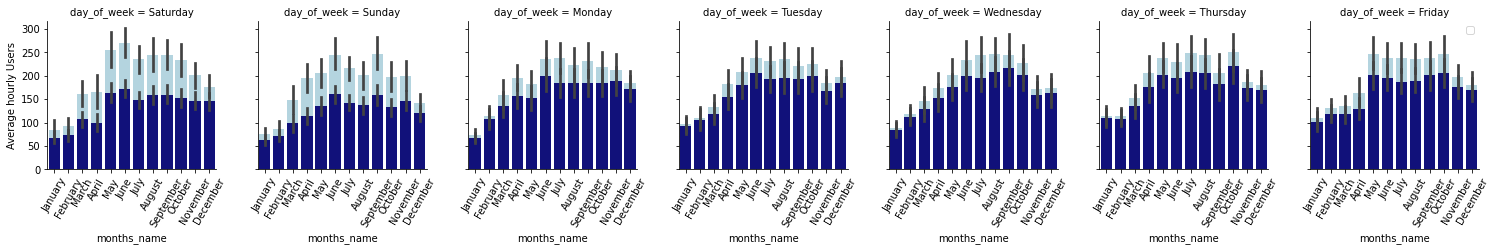

In [12]:
# averge hourly users for each months (total vs registered)
g = sns.FacetGrid(df, col="day_of_week", margin_titles=True)
g.map(sns.barplot, 'months_name', "count",  color='lightblue')
g.map(sns.barplot, 'months_name', "registered",  color='darkblue')
g.set_xticklabels(rotation = 60)

g.set_ylabels('Average hourly Users')
plt.legend()

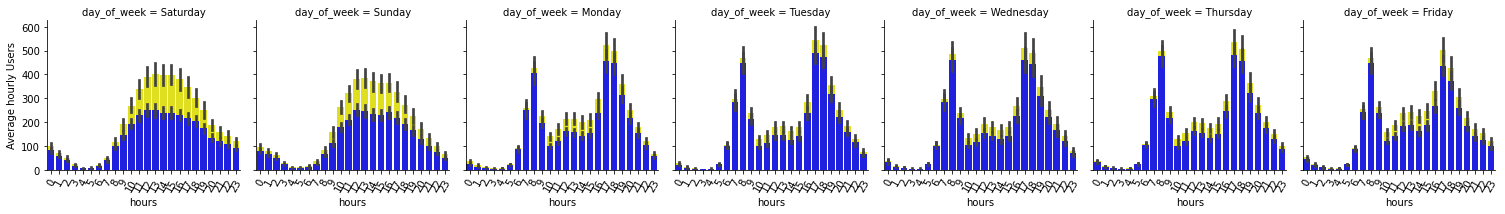

In [13]:
#average hourly users for each weekday during the day 
g = sns.FacetGrid(df, col="day_of_week", margin_titles=True)
g.map(sns.barplot, 'hours', "count",  color='yellow')
g.map(sns.barplot, 'hours', "registered",  color='blue')
g.set_xticklabels(rotation = 60)
g.set_ylabels('Average hourly Users')



<AxesSubplot:xlabel='hours', ylabel='day_of_year'>

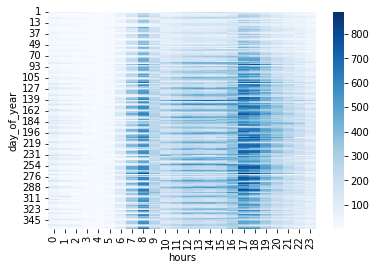

In [14]:
# heatmap for usage rate during the day over the year
df_pivot_dayofyear = pd.pivot_table(df, values='count', 
                     index=['day_of_year'], 
                     columns='hours')
    
sns.heatmap(df_pivot_dayofyear,cmap='Blues')


<AxesSubplot:xlabel='hours', ylabel='day_of_week_num'>

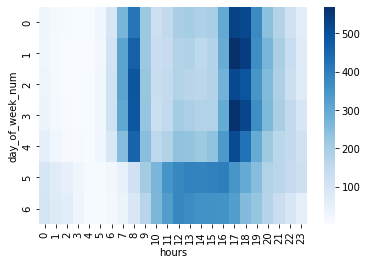

In [15]:
#heatmpa for bike usage during the day and weekday
df_pivot_median = pd.pivot_table(df, values='count', 
                     index=['day_of_week_num'], 
                     columns='hours', aggfunc = 'median')
    
sns.heatmap(df_pivot_median,cmap='Blues')

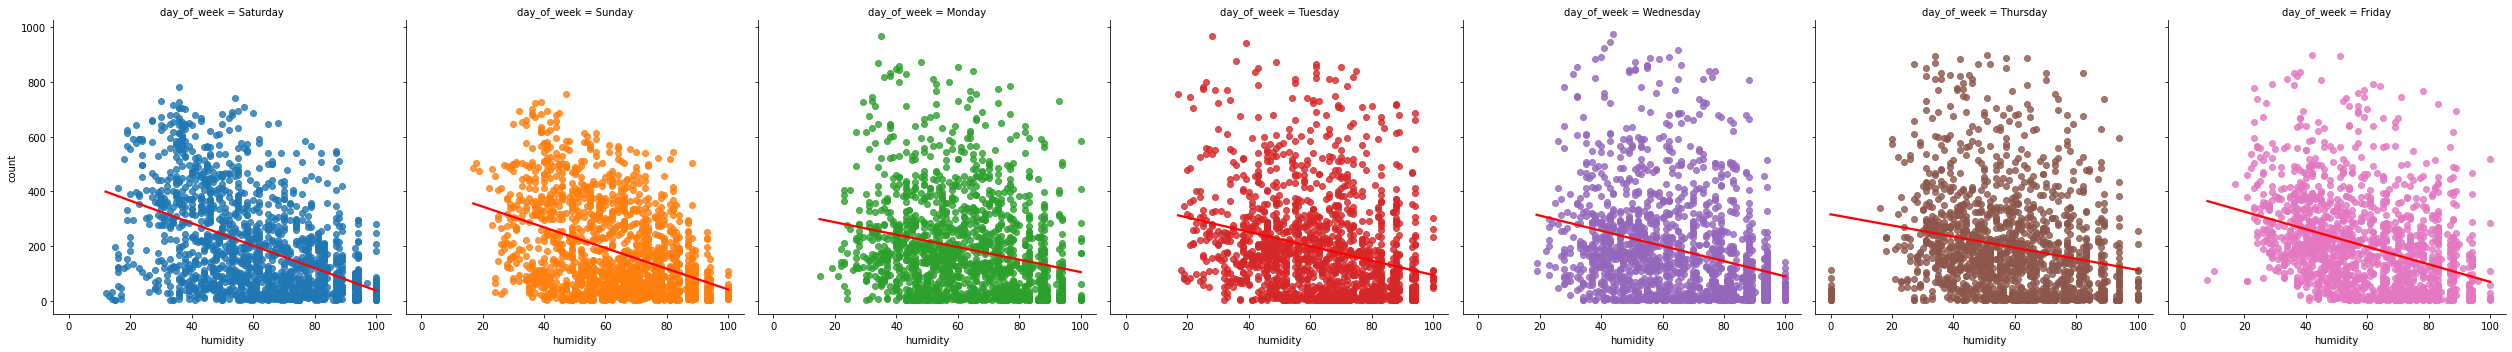

In [16]:
# bike usage vs humidity
sns.lmplot(data = df, x = 'humidity', y = 'count', col = 'day_of_week', hue = 'day_of_week', ci = None, line_kws={'color': 'red'})

<Figure size 360x360 with 0 Axes>

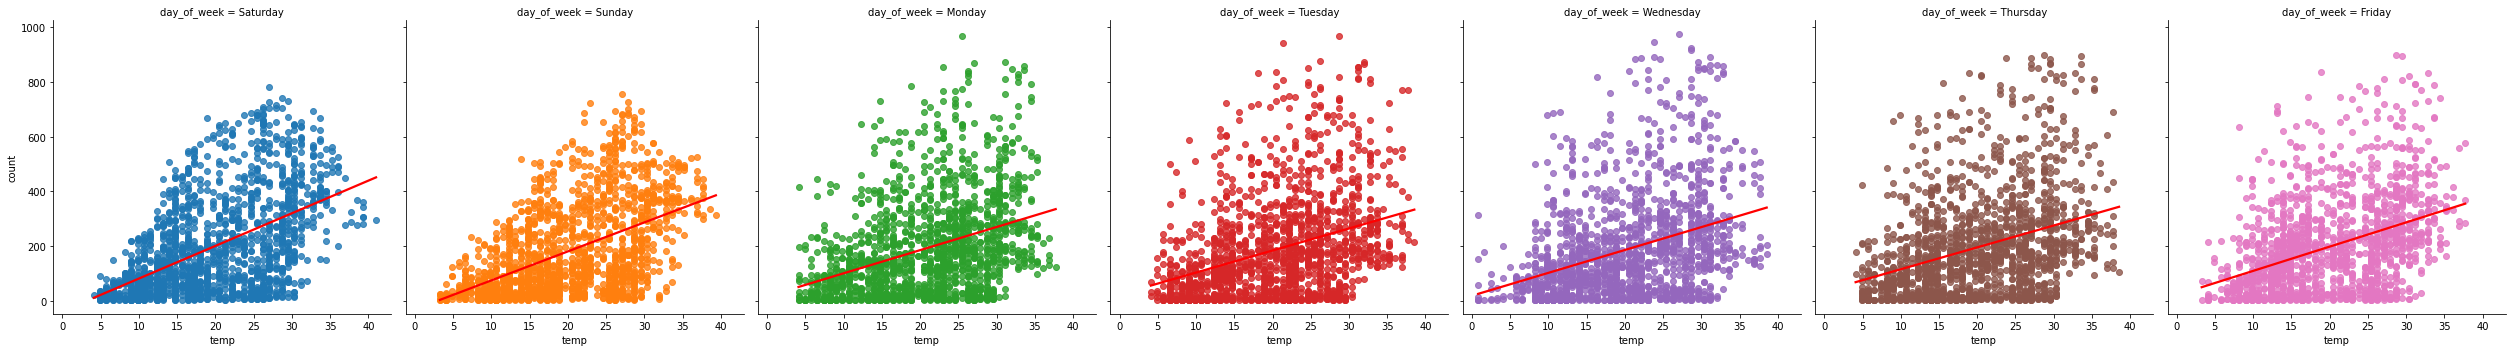

In [17]:
#bike usage vs temperature
plt.figure(figsize=(5,5))
sns.lmplot(data = df, x = 'temp', y = 'count', col = 'day_of_week', hue = 'day_of_week', ci = None, line_kws={'color': 'red'})

<AxesSubplot:xlabel='hours', ylabel='casual'>

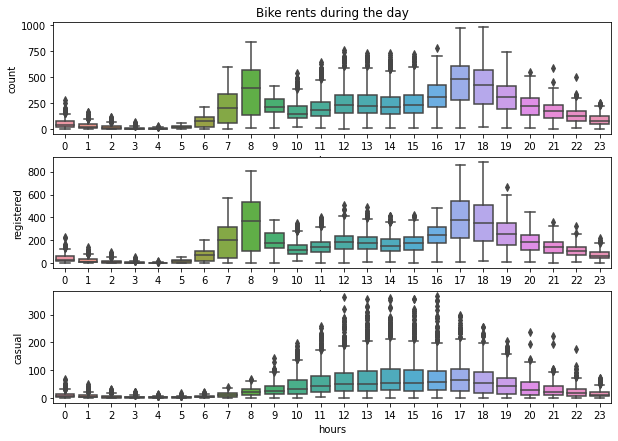

In [18]:
#boxplot of bike rents for each hour split by all users, regesitered users and casual users
fig,ax = plt.subplots(3,1 , figsize=(10,7))
sns.boxplot(data=df,x='hours',y='count',ax=ax[0]).set(title="Bike rents during the day")
sns.boxplot(data=df,x='hours',y='registered',ax=ax[1])
sns.boxplot(data=df,x='hours',y='casual',ax=ax[2])


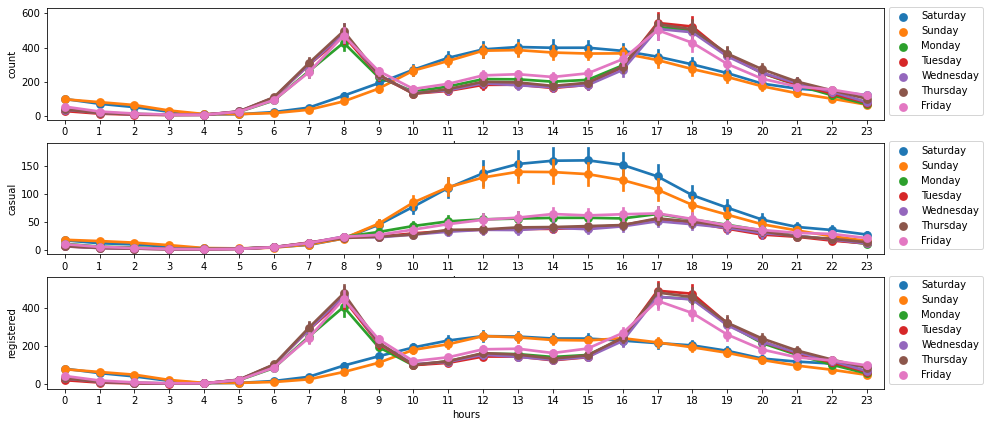

In [19]:
# average bike rents per hour for each weekday split by all users, casual users, registered users
fig, ax = plt.subplots(3,1, figsize=(15,7))

sns.pointplot(data=df, x='hours', y='count', hue='day_of_week', ax = ax[0])
ax[0].legend(loc='lower left', bbox_to_anchor=(1.0, 0))
sns.pointplot(data=df, x='hours', y='casual', ax = ax[1], hue='day_of_week')
ax[1].legend(loc='lower left', bbox_to_anchor=(1.0, 0))
sns.pointplot(data=df, x='hours', y='registered', hue='day_of_week',ax = ax[2])
ax[2].legend(loc='lower left', bbox_to_anchor=(1.0, 0))

# Split the data into a training and test dataset

In [20]:
# split data in X and y
y_count = df['count']
y_registered = df['registered']
y_casual = df['casual']
X = df.drop(['count','registered','casual'], axis = 1)

X.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,months_num,months_name,day_of_week_num,day_of_week,hours,year,day_of_year
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1,January,5,Saturday,0,2011,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,1,January,5,Saturday,1,2011,1


In [21]:
#split data in test and training
X_train, X_test, y_train, y_test = train_test_split(X, y_count, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 15), (2722, 15), (8164,), (2722,))

# Build the pipeline to transform the variables in the columns

## Pipeline

In [23]:
my_polynomial_expansion = Pipeline([
    ('my_polynomial', PolynomialFeatures()),
])

In [24]:
my_onehot_poly = Pipeline([
    ('my_one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [25]:
my_scaler_poly = Pipeline([
    ('my_scaler',StandardScaler()),
])

In [26]:
my_scaler = Pipeline([
    ('my_one_hot', OneHotEncoder()),
])

In [27]:
X_train.shape

(8164, 15)

In [28]:
y_train.shape

(8164,)

## Column Transformer

In [29]:
# transform columns in a pipeline
ct = ColumnTransformer([
    ('pipeline', my_onehot_poly, ['season','weather','months_num','day_of_week_num','year','hours']),
    ('pipeline2', my_scaler_poly, ['temp','humidity','windspeed']),  
    ('my_passthrough', 'passthrough', ['workingday'])
  
])

## Create Dataframe of Trained and Fitted Data

In [30]:
Xtrain_preprocess = ct.fit_transform(X_train)

In [31]:
Xtrain_preprocess.shape

(8164, 57)

In [32]:
ct.get_feature_names_out()

array(['pipeline__season_1', 'pipeline__season_2', 'pipeline__season_3',
       'pipeline__season_4', 'pipeline__weather_1', 'pipeline__weather_2',
       'pipeline__weather_3', 'pipeline__weather_4',
       'pipeline__months_num_1', 'pipeline__months_num_2',
       'pipeline__months_num_3', 'pipeline__months_num_4',
       'pipeline__months_num_5', 'pipeline__months_num_6',
       'pipeline__months_num_7', 'pipeline__months_num_8',
       'pipeline__months_num_9', 'pipeline__months_num_10',
       'pipeline__months_num_11', 'pipeline__months_num_12',
       'pipeline__day_of_week_num_0', 'pipeline__day_of_week_num_1',
       'pipeline__day_of_week_num_2', 'pipeline__day_of_week_num_3',
       'pipeline__day_of_week_num_4', 'pipeline__day_of_week_num_5',
       'pipeline__day_of_week_num_6', 'pipeline__year_2011',
       'pipeline__year_2012', 'pipeline__hours_0', 'pipeline__hours_1',
       'pipeline__hours_2', 'pipeline__hours_3', 'pipeline__hours_4',
       'pipeline__hours_5', 'pip

In [33]:
# create matrix
Xtrain_preprocess.todense()

matrix([[ 0.        ,  0.        ,  1.        , ...,  0.16436946,
          0.02516201,  1.        ],
        [ 0.        ,  1.        ,  0.        , ..., -0.51079345,
          1.12151526,  1.        ],
        [ 0.        ,  1.        ,  0.        , ..., -0.04337298,
         -0.82646953,  1.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.71853589,
          0.51215821,  0.        ],
        [ 1.        ,  0.        ,  0.        , ..., -2.32853975,
          2.70404896,  0.        ],
        [ 0.        ,  1.        ,  0.        , ...,  1.35888846,
          0.02516201,  1.        ]])

In [34]:
Xtrain_preprocess_df = pd.DataFrame(Xtrain_preprocess.todense(),columns=ct.get_feature_names_out())
Xtrain_preprocess_df

,pipeline__season_1,pipeline__season_2,pipeline__season_3,pipeline__season_4,pipeline__weather_1,pipeline__weather_2,pipeline__weather_3,pipeline__weather_4,pipeline__months_num_1,pipeline__months_num_2,...,pipeline__hours_18,pipeline__hours_19,pipeline__hours_20,pipeline__hours_21,pipeline__hours_22,pipeline__hours_23,pipeline2__temp,pipeline2__humidity,pipeline2__windspeed,my_passthrough__workingday
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.084597,0.164369,0.025162,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.348279,-0.510793,1.121515,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.019170,-0.043373,-0.826470,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.453467,-0.095309,-0.461834,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.545112,1.618566,0.025162,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8159,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.755488,-0.770471,-0.217928,0.0
8160,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.124358,-0.043373,0.756064,0.0
8161,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.124358,-0.718536,0.512158,0.0
8162,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.598417,-2.328540,2.704049,0.0


In [35]:
X_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,months_num,months_name,day_of_week_num,day_of_week,hours,year,day_of_year
datetime,,,,,,,,,,,,,,,
2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,7,July,0,Monday,0,2011,192
2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,5,May,4,Friday,22,2012,139
2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,4,April,4,Friday,23,2011,91
2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,9,September,6,Sunday,9,2012,260
2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,2,February,1,Tuesday,23,2011,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,1,0,0,1,6.56,8.335,47,11.0014,1,January,5,Saturday,2,2012,14
2011-12-10 09:00:00,4,0,0,1,11.48,12.880,61,19.0012,12,December,5,Saturday,9,2011,344
2011-12-18 16:00:00,4,0,0,1,11.48,13.635,48,16.9979,12,December,6,Sunday,16,2011,352


# Create Pipeline for each model & Run the models & Cross Validate

In [36]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## Linear Regression

### Build Pipeline

In [37]:
# build final pipeline out of column transfomer plus polynomial expansion
# use linear regression for forecasting
final_pipeline_linear = Pipeline([
    ('ct', ct),
    ('poly', my_polynomial_expansion),
    ('linear', LinearRegression())
])

In [38]:
final_pipeline_linear.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('my_one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'weather',
                                                   'months_num',
                                                   'day_of_week_num', 'year',
                                                   'hours']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('my_scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('my_passthrough',
                                                  'passthrough',
                                                  ['workingday'])])),
                ('poly',
                 Pipeline(steps=[('my_polynomial', PolynomialFeatures())])),
                ('linear', LinearRegression())])

### Scores for Test and Training on Linear Regression

In [39]:
# calculate the cores for the train and test prediction
print(f'The training score for linear regression is: {final_pipeline_linear.score(X_train, y_train).round(5)}')
print(f'The test score for linear regression is: {final_pipeline_linear.score(X_test, y_test).round(5)}')

The training score for linear regression is: 0.93784
The test score for linear regression is: 0.91934


### Cross Validate Linear Regression

In [40]:
# cross validate to check for robustness
scores = cross_val_score(final_pipeline_linear,X_train,y_train,cv=6,scoring='r2',error_score='raise') # Kfold used for regression problems
scores

array([0.90468457, 0.92223913, 0.92717743, 0.92134969, 0.91427983,
       0.92234515])

In [41]:
# mean of cross validation scores
scores.mean()

0.918679300132689

## Lasso Regressor

### Build Pipeline

In [44]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [47]:
lasso_pipeline = Pipeline([
    ('ct', ct),
    ('poly', my_polynomial_expansion),
    ('selecKbest', SelectKBest(k=1200)),
    ('Lasso', Lasso(alpha = 0.1)),#class_weight='balanced'))
    
])
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('my_one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'weather',
                                                   'months_num',
                                                   'day_of_week_num', 'year',
                                                   'hours']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('my_scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('my_passthrough',
                                                  'passthrough',
                                                  ['workingday'])])),
                ('poly',
                 Pipeline(steps=[('my_polynomial', PolynomialFeatures())])),
                ('selecKbest', SelectKBest(k=1200)),
                ('Lasso', Lasso(alpha=0.1))])

### Scores for Test and Training on Lasso

In [48]:
print(f'The training score for lasso is: {lasso_pipeline.score(X_train, y_train).round(5)}')
print(f'The test score for lasso is: {lasso_pipeline.score(X_test, y_test).round(5)}')

The training score for lasso is: 0.92302
The test score for lasso is: 0.91612


### Cross Validate

In [49]:
# cross validate for robustness
scores = cross_val_score(lasso_pipeline,X_train,y_train,cv=5,scoring='r2',error_score='raise') # Kfold used for regression problems
scores.mean()

0.9113363277295301

### Hyperparameter Optimization

In [50]:
lasso_pipeline.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('my_one_hot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['season', 'weather', 'months_num',
                                     'day_of_week_num', 'year', 'hours']),
                                   ('pipeline2',
                                    Pipeline(steps=[('my_scaler',
                                                     StandardScaler())]),
                                    ['temp', 'humidity', 'windspeed']),
                                   ('my_passthrough', 'passthrough',
                                    ['workingday'])])),
  ('poly', Pipeline(steps=[('my_polynomial', PolynomialFeatures())])),
  ('selecKbest', SelectKBest(k=1200)),
  ('Lasso', Lasso(alpha=0.1))],
 'verbose': False,
 'ct': ColumnTransformer(transformers=[('pipeline',
           

In [78]:
# choose hyperparameters for optimization
hyperparams_lasso = {
    'selecKbest__k':np.arange(1200,1300,50),
    'Lasso__alpha':np.arange(0.05,0.1,0.1),

}

In [79]:
# create grid search object for parameter optimization
hyper_lasso = GridSearchCV(lasso_pipeline, hyperparams_lasso)

In [80]:
# fit the model
hyper_lasso.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('my_one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['season',
                                                                          'weather',
                                                                          'months_num',
                                                                          'day_of_week_num',
                                                                          'year',
                                                                          'hours']),
                                                                        ('pipeline2',
                                                                         Pipeline(steps=[('my_scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          'windspeed']),
                                                                        ('my_passthrough',
                                                                         'passthrough',
                                                                         ['workingday'])])),
                                       ('poly',
                                        Pipeline(steps=[('my_polynomial',
                                                         PolynomialFeatures())])),
                                       ('selecKbest', SelectKBest(k=1200)),
                                       ('Lasso', Lasso(alpha=0.1))]),
             param_grid={'Lasso__alpha': array([0.05]),
                         'selecKbest__k': array([1200, 1250])})

In [81]:
# get the best parameters
hyper_lasso.best_params_

{'Lasso__alpha': 0.05, 'selecKbest__k': 1250}

In [82]:
# get the best score 
hyper_lasso.best_score_

0.917625228095282

In [83]:
pd.DataFrame({'params':hyper_lasso.cv_results_['params'], 'mean_fit_time':hyper_lasso.cv_results_['mean_fit_time'], 'mean_test_score':hyper_lasso.cv_results_['mean_test_score']}).sort_values(by = 'mean_test_score', ascending= False)

,params,mean_fit_time,mean_test_score
1,"{'Lasso__alpha': 0.05, 'selecKbest__k': 1250}",20.587056,0.917625
0,"{'Lasso__alpha': 0.05, 'selecKbest__k': 1200}",17.663949,0.917471


## Random Forest Regressor

### Build Pipeline

In [42]:
from sklearn.ensemble import RandomForestRegressor

final_pipeline_random = Pipeline([
    ('ct', ct),
    ('RandomForest', RandomForestRegressor(n_jobs=-1)),#class_weight='balanced'))
    
])
final_pipeline_random.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('my_one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'weather',
                                                   'months_num',
                                                   'day_of_week_num', 'year',
                                                   'hours']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('my_scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('my_passthrough',
                                                  'passthrough',
                                                  ['workingday'])])),
                ('RandomForest', RandomForestRegressor(n_jobs=-1))])

### Scores for Test and Training on Random Forest Regressor

In [43]:
print(f'The training score for random forest is: {final_pipeline_random.score(X_train, y_train).round(5)}')
print(f'The test score for random forest is: {final_pipeline_random.score(X_test, y_test).round(5)}')

The training score for random forest is: 0.98844
The test score for random forest is: 0.9284


### Hyperparameter Optimization

In [44]:
final_pipeline_random.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('my_one_hot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['season', 'weather', 'months_num',
                                     'day_of_week_num', 'year', 'hours']),
                                   ('pipeline2',
                                    Pipeline(steps=[('my_scaler',
                                                     StandardScaler())]),
                                    ['temp', 'humidity', 'windspeed']),
                                   ('my_passthrough', 'passthrough',
                                    ['workingday'])])),
  ('RandomForest', RandomForestRegressor(n_jobs=-1))],
 'verbose': False,
 'ct': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('my_one_hot',
                                 

In [50]:
# define the ranges within which certain parameters should be optimized
hyperparams = {
    'RandomForest__max_depth':np.arange(25,35,5),
    'RandomForest__n_estimators':np.arange(0,200,100)
    
}

In [51]:
g2 = GridSearchCV(final_pipeline_random, hyperparams)

In [52]:
g2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('my_one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['season',
                                                                          'weather',
                                                                          'months_num',
                                                                          'day_of_week_num',
                                                                          'year',
                                                                          'hours']),
                                                                        ('pipeline2',
                                                                         Pipeline(steps=[('my_scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          'windspeed']),
                                                                        ('my_passthrough',
                                                                         'passthrough',
                                                                         ['workingday'])])),
                                       ('RandomForest',
                                        RandomForestRegressor(n_jobs=-1))]),
             param_grid={'RandomForest__max_depth': array([25, 30]),
                         'RandomForest__n_estimators': array([  0, 100])})

In [53]:
g2.best_params_

{'RandomForest__max_depth': 30, 'RandomForest__n_estimators': 100}

In [54]:
g2.best_score_

0.9101095298356603

In [55]:
pd.DataFrame({'params':g2.cv_results_['params'], 'mean_fit_time':g2.cv_results_['mean_fit_time'], 'mean_test_score':g2.cv_results_['mean_test_score']}).sort_values(by = 'mean_test_score', ascending= False)

,params,mean_fit_time,mean_test_score
3,"{'RandomForest__max_depth': 30, 'RandomForest_...",8.812961,0.910110
1,"{'RandomForest__max_depth': 25, 'RandomForest_...",8.612693,0.907988
0,"{'RandomForest__max_depth': 25, 'RandomForest_...",0.027594,NaN
2,"{'RandomForest__max_depth': 30, 'RandomForest_...",0.021486,NaN


In [56]:
g2.score(X_test, y_test)

0.9283812893441253

## Ridge

### Scores for Test and Training for Ridge

In [59]:
#import Ridge regressor
from sklearn.linear_model import Ridge

In [60]:
final_pipeline_ridge = Pipeline([
    ('ct', ct),
    ('poly', my_polynomial_expansion),
    ('Ridge', Ridge(alpha=0.001)),#class_weight='balanced'))
    
])
final_pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('my_one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'weather',
                                                   'months_num',
                                                   'day_of_week_num', 'year',
                                                   'hours']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('my_scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('my_passthrough',
                                                  'passthrough',
                                                  ['workingday'])])),
                ('poly',
                 Pipeline(steps=[('my_polynomial', PolynomialFeatures())])),
                ('Ridge', Ridge(alpha=0.001))])

In [61]:
print(f'The training score for ridge is: {final_pipeline_ridge.score(X_train, y_train).round(5)}')
print(f'The test score for ridge is: {final_pipeline_ridge.score(X_test, y_test).round(5)}')

The training score for ridge is: 0.9377
The test score for ridge is: 0.91977


### Cross Validate Ridge

In [62]:
scores = cross_val_score(final_pipeline_ridge,X_train,y_train,cv=5,scoring='r2',error_score='raise') # Kfold used for regression problems
# StratifiedKfold used for classification problems
scores.mean()

0.9181653974534495

## Poisson

### Scores for TEst and Training Poisson

In [68]:

final_pipeline_poisson = Pipeline([
    ('ct', ct),
    ('poly', my_polynomial_expansion),
    ('poissin', PoissonRegressor()),#class_weight='balanced'))
    
])
final_pipeline_poisson.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('my_one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'weather',
                                                   'months_num',
                                                   'day_of_week_num', 'year',
                                                   'hours']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('my_scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('my_passthrough',
                                                  'passthrough',
                                                  ['workingday'])])),
                ('poly',
                 Pipeline(steps=[('my_polynomial', PolynomialFeatures())])),
                ('poissin', PoissonRegressor())])

In [69]:
print(f'The training score for poisson is: {final_pipeline_poisson.score(X_train, y_train).round(5)}')
print(f'The test score for poisson is: {final_pipeline_poisson.score(X_test, y_test).round(5)}')

The training score for poisson is: 0.94176
The test score for poisson is: 0.9326


## Predicting and Plotting




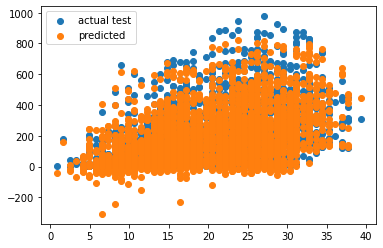

In [71]:
y_pred = final_pipeline_linear.predict(X_test)
plt.scatter(X_test['temp'], y_test, label="actual test")
plt.scatter(X_test['temp'], y_pred, label="predicted")
plt.legend()

### Histplot for Linear Regression

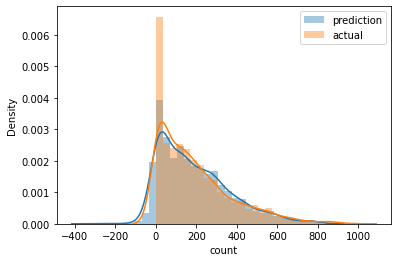

In [72]:
y_pred = final_pipeline_linear.predict(X_test)
sns.distplot(y_pred, label='prediction')
sns.distplot(y_test, label='actual')
plt.legend()

### Histplot for Poisson Regression

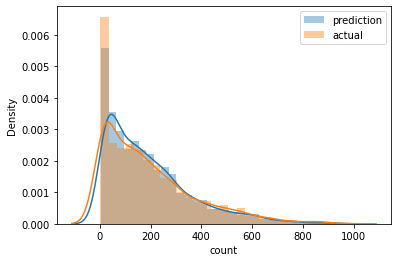

In [74]:
y_pred = final_pipeline_poisson.predict(X_test)
sns.distplot(y_pred, label='prediction')
sns.distplot(y_test, label='actual')
plt.legend()